# Fraud Detection
This notebook translates, corrects, and extends a project, "Evaluating techniques for classifying highly imbalanced data," Burke, L. and T. Cunnington. AMath 583 Final Project, University of Washington: Winter 2017.

1. [Introduction](#introduction)
 1. Visualizing the Features
 2. Class Imbalance
 3. Precision and Recall
 4. ROC Curve
 5. F Score
2. [Imbalanced Learning](#imbalanced)
 1. Oversampling
 2. Undersampling
 3. Combined Over-/Undersampling
 4. Other Methods
3. [Application](#application)
4. Conclusion

<a id='introduction'></a>

## 1. Introduction

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd

import numpy as np
np.random.seed(0)
random_state = np.random.RandomState(0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.ioff()

import seaborn as sns
sns.set(context='notebook', style='white', color_codes=True)

filename = 'creditcard.csv'
data = pd.read_csv(filename)

data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Visualizing the Features

In [ ]:
plot_data = data.sample(frac=0.1)

# Create pair-wise scatter plots; on diagonal show kernal density estimation
_ = sns.pairplot(plot_data, vars=['V1','V2','V3'], hue='Class', diag_kind='kde', plot_kws={"s": 7}, size=1.5);
plt.show()


### Class Imbalance

In [ ]:
n = data['Class'].count()
n_fraud = np.sum(data['Class'])
print("There are {} instances of fraud in {} transactions (that's {:.2%}).".format(n_fraud, n, n_fraud/n))

### Precision and Recall
This strong class imbalance is a challenge for a predictive model: classifying all transactions as legitimate yields 99.8% accuracy. We must instead look for more informative metrics. We consider here *precision* and *recall*. Formally, call fraudulent samples 'positive' and legitimate samples 'negative', and consider the confusion matrix of a classifier:

|| positive | negative |
|---:|:---:|:---:|
| predicted positive | True Positive (TP) | False Positive (FP) |
| predicted negative | False Negative (FN) | True Negative (TN) |

Overall accuracy is then, as usual, the ratio of correct to total predictions,
$$ \frac{ TP + TN }{ TP + TN + FP + FN } $$
Precision is the accuracy of positive predictions,
$$ \frac{ TP }{ TP + FP }, $$
and recall is the accuracy over positive samples,
$$ \frac{ TP }{ TP + FN }. $$ 

There is a trade-off between recall and precision: more positive predictions can increase recall, but decrease precision. Indeed, making only predictions of fraud yields a recall of 100%, but only 0.17% precision. Because we are trying to find these rare cases of fraud, we should be privileging recall in this context, but perhaps not that much.

Suppose we construct a classifier which, instead of simply assignign a label, assigns to each test sample the probability of being fraudulent. We can then set a global *threshold*, and if the assigned probability is greater than that threshold, we label that sample fraudulent. This allows us to directly investigate the trade-off of precision and recall for any given classifier: as the threshold is increased from 0 to 1, fewer predictions of fraud are made, but more of them are correct.

The usual visualization of this process plots precision against recall parametrically (recall always increases monotonically with the threshold, so we can use recall as the independent variable), sometimes abbreviated *PR curve*. Note that this curve is parameterized by the threshold, so recall and precision may not be one-to-one (i.e., there may be multiple values of precision for a single value of recall).

A perfect classifier assigns probability 1 to all positive samples, and 0 to all negative samples. Hence, if the threshold is 1 then nothing is labeled positive, so the recall is 0 but the precision is undefined (. If the threshold is greater than 0 then everything is classified perfectly, and both precision and recall are 1. If the threshold is exactly 0 then everything is labeled positive, so recall is 1 but precision is $\rho$, the ratio of the smaller class to the total size of the dataset (e.g., for this experiment $\rho\approx0.0017$). All this is to say that that the PR curve for a perfect classifier is really two points: $(1,1)$ and $(1,\rho)$, where$\rho$ is the ratio of the smaller class to the total size of the dataset.

Call the threshold $\eta$. When $\eta=1$ then nothing is labeled positive, so the recall is 0 but the precision is undefined (it approaches either 0 or 1, depending on whether the sample with the highest predicted probability is actually positive or negative, respectively). If $\eta=0$ then everything is labeled positive, so recall is 1 but precision is $\rho$, the ratio of the smaller class to the total size of the dataset (e.g., for this experiment $\rho\approx0.0017$). In general, PR curves for classifiers move from $(1,\rho)$ to $(0,1)$ (or sometimes $(0,0)$) as the threshold is increased. 

A perfect classifier assigns probability 1 to all positive samples, and 0 to all negative samples. Then everything is classified perfectly when $0<\eta<1$, and both precision and recall are 1. Better classifiers have PR curves which are close to this upper right corner.

One way to summarize this plot into a single number is the area under the PR curve (AUCPR): it will vary between 0 and 1, with 1 being perfect. There are multiple ways to compute this, but here I use the built-in `scikit-learn` utility `auc`, which implements a simple trapezoidal rule. Later, I use 10-fold cross validation to increase confidence in the results. Note that it is not possible to construct valid confidence intervals with this method. See [Boyd, Eng, and Page (2013)](pages.cs.wisc.edu/~boyd/aucpr_final.pdf).

In [ ]:
### Plot example PR Curve and calculate its AUC
## Copied from scikit-learn docs, except (1) to suppress output, 
##                                       (2) to show AUC instead of AP,
##                                       (3) to plot perfect classifier, and
##                                       (4) to change plot appearance slightly
## http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Add noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# Limit to the two first classes, and split into training and test
X_train, X_test, y_train, y_test = train_test_split(X[y < 2], y[y < 2],
                                                    test_size=.5,
                                                    random_state=random_state)

# Create a simple classifier
classifier = svm.LinearSVC(random_state=random_state)
_ = classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_test, y_score)
auc = auc(recall[::-1], precision[::-1]) 

plt.figure(figsize=(6,6))
_ = plt.step(recall, precision, color='b', alpha=0.8, where='post')
#_ = plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
_ = plt.plot([0,0],[1,1],color='b', alpha=0.8, label='SVC')

rho = y[y==1].size*1.0 / y[y<2].size
_ = plt.plot([0, 1], [1, 1], linestyle='-', lw=2, color='r', alpha=.8);
_ = plt.plot([1, 1], [1,rho], linestyle='-', lw=2, color='r', label='Perfect', alpha=.8);

_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.ylim([0.0, 1.05])
_ = plt.xlim([0.0, 1.05])
_ = plt.legend(loc="lower left");
_ = plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          auc))
plt.show()

### ROC Curve
A receiver operating characteristic curve is similar to a PR curve, plotting the true positive rate (i.e., recall) against the false positive rate (one minus the accuracy of negative predictions). The ROC curve (and associated area-under-the-curve AUROC) is frequently used to compare classifiers, but is sensitive to class imbalance: when there are many more negative samples than positive, a large change in false positives does not result in a large change of the false positive rate. Using precision instead of the false positive rate shows this effect more clearly.

The ROC and PR curves are largely interchangeable, but not exactly. It is true that ROC and PR curves are bijective (each ROC curve is associated with exactly one PR curve, and vice versa). It is also true that if and only if an ROC curve *dominates* another (i.e., is greater than or equal to at every point) then the associated PR curve also dominates the other. However, it is not necessarily true that an ROC curve with greatest AUROC has a PR curve with greatest AUCPR. See [Davis and Goadrich (2006)](http://www.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf).

### F-Score
Besides the area under the PR curve, the F-score is another way to balance precision and recall into a single score, using the parameter $\beta$:

$$ F^\beta = (1+\beta^2) \frac{ (\text{precision})(\text{recall}) }{ \beta^2 ( \text{precision} ) + \text{recall} }. $$

For $\beta=0$, $F^0$ is just precision, and when $\beta\rightarrow\infty$, $F^\infty$ is recall. In the middle is $\beta=1$, where $F^1$ is proportional to the harmonic sum of precision and recall:

$$ F^1 = \frac{ 2 }{ \frac{ 1 }{ \text{precision} } + \frac{ 1 }{ \text{recall} } }. $$

The choice of $\beta$ is ultimately a business decision: how much undetected fraud is worth the hassle of false positives? We can visualize the effect of $\beta$ by plotting iso-$F^\beta$ curves on a precision-recall plot (i.e., curves of (recall, precision) where $F^\beta$ is constant).

In [ ]:
### Adapted from sklearn docs
## http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
N = 500

plt.figure(figsize=(10,4))
i=1
for beta in [0.25,1,4]:
    _ = plt.subplot(1, 3, i)
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01,1,N)
        y = f_score * x / ((1+beta**2) * x - beta**2 * f_score)
        _ = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.8)
        _ = plt.annotate('F={0:0.1f}'.format(f_score), xy=(0.8, y[450] + 0.02))
    
    fig = plt.gcf()
    _ = fig.subplots_adjust(bottom=0.25)
    _ = plt.xlim([0.0, 1.0])
    _ = plt.ylim([0.0, 1.05])
    if i==2:
        _ = plt.xlabel('Recall')
    if i==1:
        _ = plt.ylabel('Precision')
    _ = plt.title('beta={}'.format(beta))
    
    i = i+1
_ = plt.suptitle('Iso-Fbeta Curves')


plt.show()

<a id='imbalanced'></a>

## 2. Imbalanced Learning

| Method | Description |
|:---:|:---|
| **Standard** | No resampling |
| **Over-Samplers** |  |
| Random Over-Sampler | Randomly over-sample |
| SMOTE | Randomly generate sample along line between any sample and one of its nearest neighbors |
| SMOTE-b1 | SMOTE, but only choose samples 'in danger' (most but not all nearest neighbors are from a different class); new sample will belong to a different class than the original |
| SMOTE-b2 | SMOTE-b1, but new sample will be chosen from any class |
| SMOTE-svc | Generate samples using SVM clasifier; extremely expensive |
| ADASYN | SMOTE, but generate more samples in neighborhoods with more class diversity |
| **Under-Samplers** |  |
| Random Under-Sampler | Randomly under-sample |
| NearMiss-1 | Keep majority samples with smallest average distance to *nearest* minority samples |
| NearMiss-2 | Keep majority samples with smallest average distance to *farthest* minority samples|
| NearMiss-3 | Keep M nearest neighbors of minority, then keep majority samples with smallest average distance to nearest minority samples |
| Tomek Links | Remove majority sample if it is mutually the nearest neighbor with another sample |
| Edited NN | Remove majority samples whose class differs from a nearest neighbor |
| Repeated Edited NN | Repeat Edited NN several times |
| All KNN | Repeat Edited NN several times, increasing number of nearest neighbors |
| Condensed NN | Discard majority samples using 1-NN |
| One-Sided Selection | Condensed NN plus Tomek Links |
| Neighbour Cleaning Rule | Edited NN, plus additional 3-NN |
| Instance Hardness Threshold | Discard low probability samples (according to some classifier) |
| **Combined Over- and Under-Samplers** |  |
| SMOTE-ENN | Pipe SMOTE into Edited NN clean-up |
| SMOTE-Tomek | Pipe SMOTE into Tomek Links clean-up |

In [10]:
### Preliminaries for comparing resampling methods
from scipy import interp
from sklearn.metrics import auc, roc_curve, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import *
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline

class DummySampler(object):
    ''' Provide imblearn interface without resampling '''

    def sample(self, X, y):
        if isinstance(X,pd.DataFrame):
            X = X.values
        if isinstance(y,pd.Series):
            y = y.values
        return X, y

    def fit(self, X, y):
        return self

    def fit_sample(self, X, y):
        return self.sample(X, y)

X, y = data.drop('Class',axis=1), data['Class']

classifier = ['DT', DecisionTreeClassifier(random_state=random_state, max_depth=5)]

samplers = [
    ['Standard', DummySampler()],
    ['ROS', RandomOverSampler(random_state=random_state)],
    ['SMOTE', SMOTE(random_state=random_state)],
    ['SMOTE-b1', SMOTE(random_state=random_state, kind='borderline1')],
    ['SMOTE-b2', SMOTE(random_state=random_state, kind='borderline2')],
#    ['SMOTE-svm', SMOTE(random_state=random_state, kind='svm')],
    ['ADASYN', ADASYN(random_state=random_state)],
#    ['RUS', RandomUnderSampler(random_state=random_state)],
#    ['NearMiss-1', NearMiss(random_state=random_state, version=1)],
#    ['NearMiss-2', NearMiss(random_state=random_state, version=2)],
#    ['NearMiss-3', NearMiss(random_state=random_state, version=3)],
#    ['Tomek', TomekLinks(random_state=random_state)],
#    ['EditedNN', EditedNearestNeighbours(random_state=random_state)],
#    ['RepeatedEditedNN', RepeatedEditedNearestNeighbours(random_state=random_state)],
#    ['AllKNN', AllKNN(random_state=random_state)],
#    ['CondensedNN', CondensedNearestNeighbour(random_state=random_state)],
#    ['OneSidedSelection', OnesidedSelection(random_state=random_state)],
#    ['NeighbourCleaning', NeighbourhoodCleaningRule(random_state=random_state)],
#    ['InstanceHardnessThreshold', InstanceHardnessThreshold(random_state=random_state)],
    ['SMOTE-ENN', SMOTEENN(random_state=random_state)],
    ['SMOTE-Tomek', SMOTETomek(random_state=random_state)],
]

pipelines = [ ['{}-{}'.format(sampler[0], classifier[0]), make_pipeline(sampler[1], classifier[1])] for sampler in samplers]

#pipelines.insert(0, ['Naive', make_pipeline(DummySampler(), DummyClassifier(strategy='prior'))])

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, random_state=random_state)


In [ ]:
### Show resampled features
plot_data = data.sample(frac=0.33)

with pd.HDFStore('store.h5') as store:
    for sampler_pair in samplers:
        print("Resampling using {}.".format(sampler_pair[0]))
        sampler = sampler_pair[1]
        resampled_data_np, y = sampler.fit_sample(plot_data.drop('Class', axis=1), plot_data['Class'])
        resampled_data = pd.DataFrame(resampled_data_np[:,1:4],columns=['V1','V2','V3'])
        resampled_data['Class'] = y
        _ = sns.pairplot(resampled_data, vars=['V1','V2','V3'], hue='Class', diag_kind='kde', plot_kws={"s": 7}, size=1)
        _ = sns.plt.suptitle(sampler_pair[0])
        plt.show()

Resampling using Standard-DT1: run 1 of 10.
Resampling using Standard-DT1: run 2 of 10.
Resampling using Standard-DT1: run 3 of 10.
Resampling using Standard-DT1: run 4 of 10.
Resampling using Standard-DT1: run 5 of 10.
Resampling using Standard-DT1: run 6 of 10.
Resampling using Standard-DT1: run 7 of 10.
Resampling using Standard-DT1: run 8 of 10.
Resampling using Standard-DT1: run 9 of 10.
Resampling using Standard-DT1: run 10 of 10.


<IPython.core.display.Javascript object>


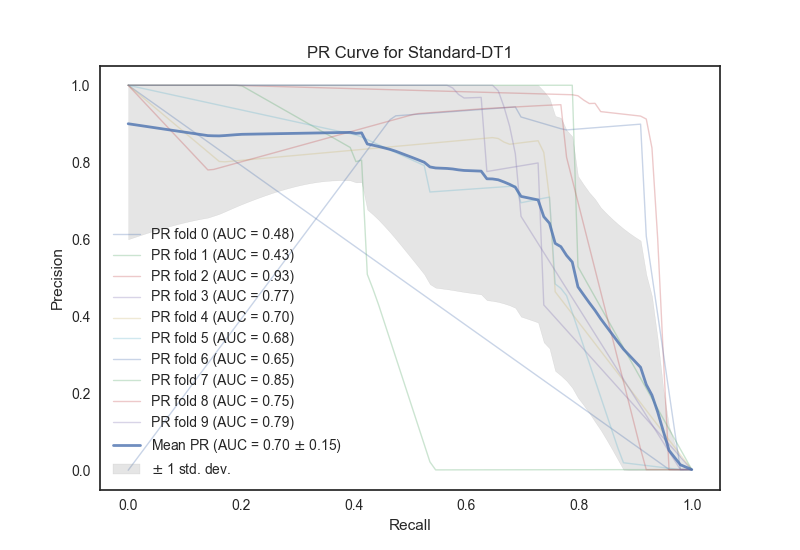

Resampling using ROS-DT1: run 1 of 10.
Resampling using ROS-DT1: run 2 of 10.
Resampling using ROS-DT1: run 3 of 10.
Resampling using ROS-DT1: run 4 of 10.
Resampling using ROS-DT1: run 5 of 10.
Resampling using ROS-DT1: run 6 of 10.
Resampling using ROS-DT1: run 7 of 10.
Resampling using ROS-DT1: run 8 of 10.
Resampling using ROS-DT1: run 9 of 10.
Resampling using ROS-DT1: run 10 of 10.


<IPython.core.display.Javascript object>


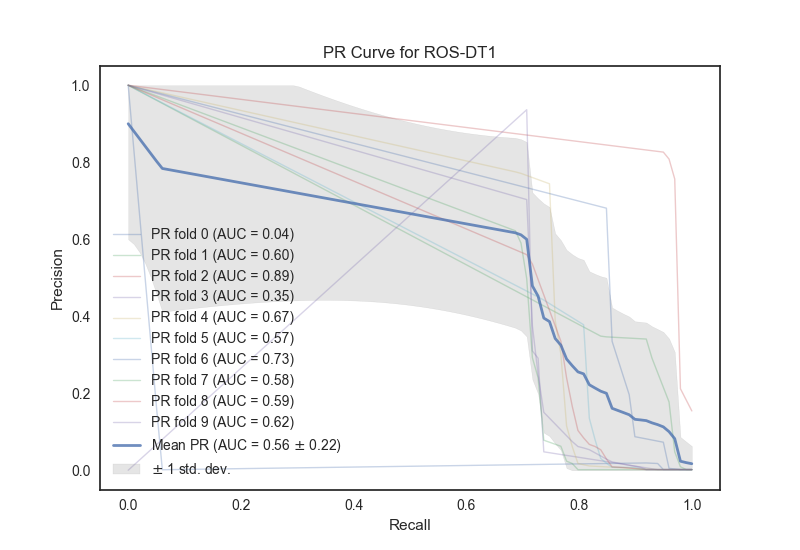

Resampling using SMOTE-DT1: run 1 of 10.
Resampling using SMOTE-DT1: run 2 of 10.
Resampling using SMOTE-DT1: run 3 of 10.
Resampling using SMOTE-DT1: run 4 of 10.
Resampling using SMOTE-DT1: run 5 of 10.
Resampling using SMOTE-DT1: run 6 of 10.
Resampling using SMOTE-DT1: run 7 of 10.
Resampling using SMOTE-DT1: run 8 of 10.
Resampling using SMOTE-DT1: run 9 of 10.
Resampling using SMOTE-DT1: run 10 of 10.


<IPython.core.display.Javascript object>


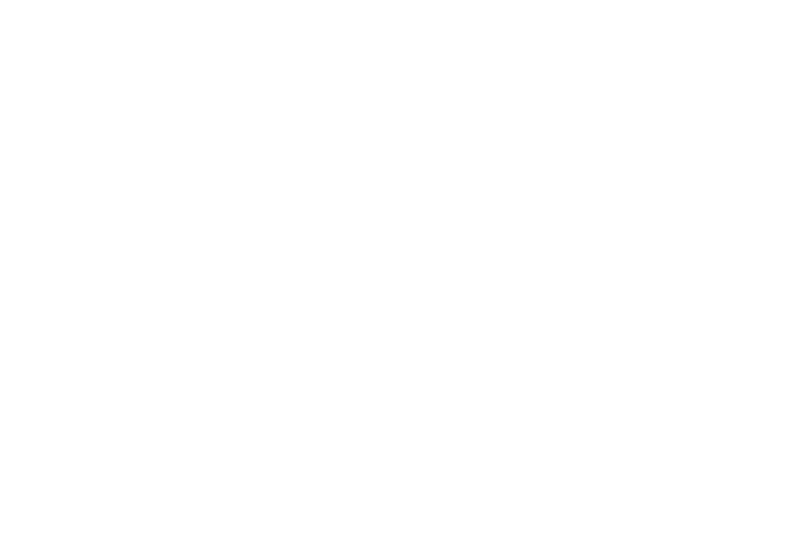

Resampling using SMOTE-b1-DT1: run 1 of 10.
Resampling using SMOTE-b1-DT1: run 2 of 10.
Resampling using SMOTE-b1-DT1: run 3 of 10.
Resampling using SMOTE-b1-DT1: run 4 of 10.
Resampling using SMOTE-b1-DT1: run 5 of 10.
Resampling using SMOTE-b1-DT1: run 6 of 10.
Resampling using SMOTE-b1-DT1: run 7 of 10.
Resampling using SMOTE-b1-DT1: run 8 of 10.
Resampling using SMOTE-b1-DT1: run 9 of 10.
Resampling using SMOTE-b1-DT1: run 10 of 10.


<IPython.core.display.Javascript object>


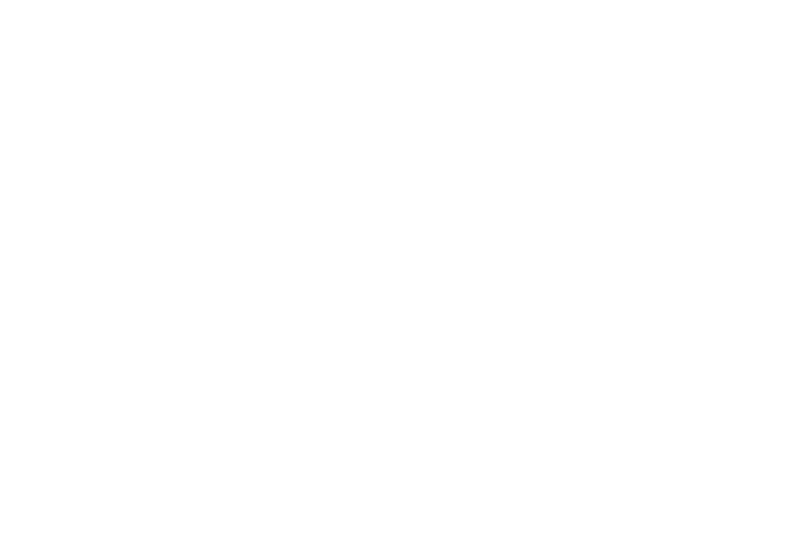

Resampling using SMOTE-b2-DT1: run 1 of 10.
Resampling using SMOTE-b2-DT1: run 2 of 10.
Resampling using SMOTE-b2-DT1: run 3 of 10.
Resampling using SMOTE-b2-DT1: run 4 of 10.
Resampling using SMOTE-b2-DT1: run 5 of 10.
Resampling using SMOTE-b2-DT1: run 6 of 10.
Resampling using SMOTE-b2-DT1: run 7 of 10.
Resampling using SMOTE-b2-DT1: run 8 of 10.
Resampling using SMOTE-b2-DT1: run 9 of 10.
Resampling using SMOTE-b2-DT1: run 10 of 10.


<IPython.core.display.Javascript object>


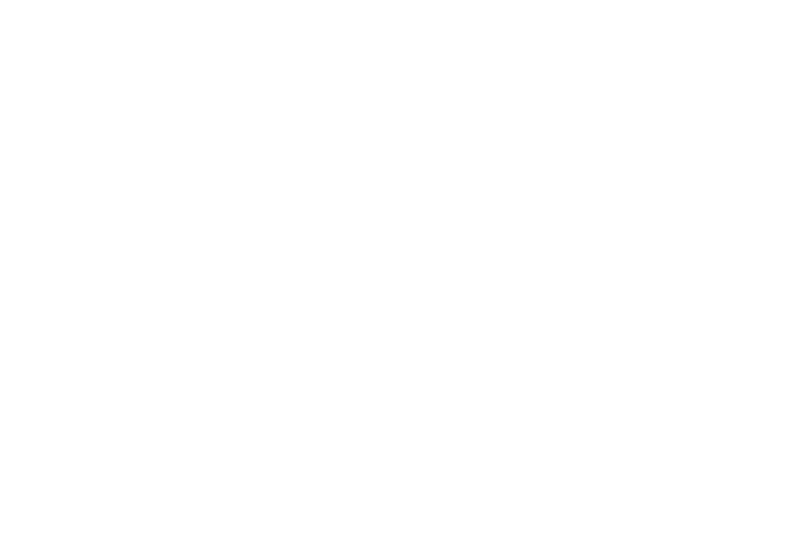

Resampling using ADASYN-DT1: run 1 of 10.
Resampling using ADASYN-DT1: run 2 of 10.
Resampling using ADASYN-DT1: run 3 of 10.
Resampling using ADASYN-DT1: run 4 of 10.
Resampling using ADASYN-DT1: run 5 of 10.
Resampling using ADASYN-DT1: run 6 of 10.
Resampling using ADASYN-DT1: run 7 of 10.
Resampling using ADASYN-DT1: run 8 of 10.
Resampling using ADASYN-DT1: run 9 of 10.
Resampling using ADASYN-DT1: run 10 of 10.


<IPython.core.display.Javascript object>


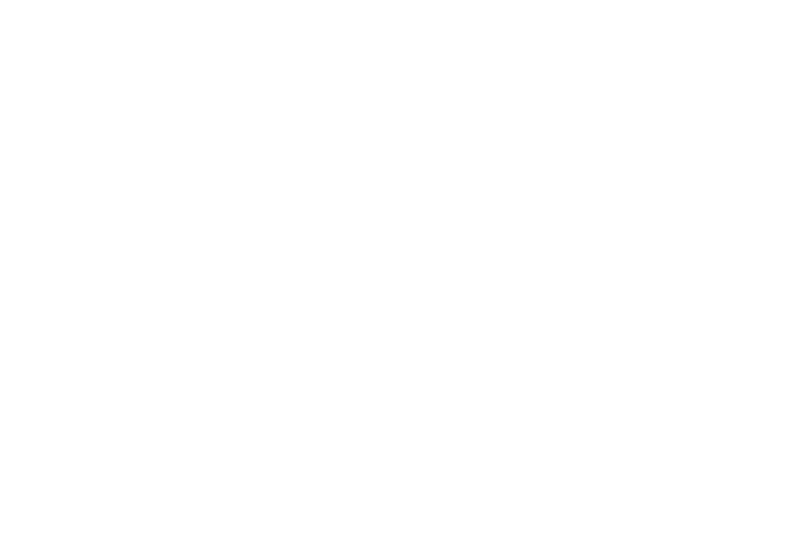

Resampling using SMOTE-ENN-DT1: run 1 of 10.
Resampling using SMOTE-ENN-DT1: run 2 of 10.
Resampling using SMOTE-ENN-DT1: run 3 of 10.
Resampling using SMOTE-ENN-DT1: run 4 of 10.
Resampling using SMOTE-ENN-DT1: run 5 of 10.
Resampling using SMOTE-ENN-DT1: run 6 of 10.
Resampling using SMOTE-ENN-DT1: run 7 of 10.
Resampling using SMOTE-ENN-DT1: run 8 of 10.
Resampling using SMOTE-ENN-DT1: run 9 of 10.
Resampling using SMOTE-ENN-DT1: run 10 of 10.


<IPython.core.display.Javascript object>


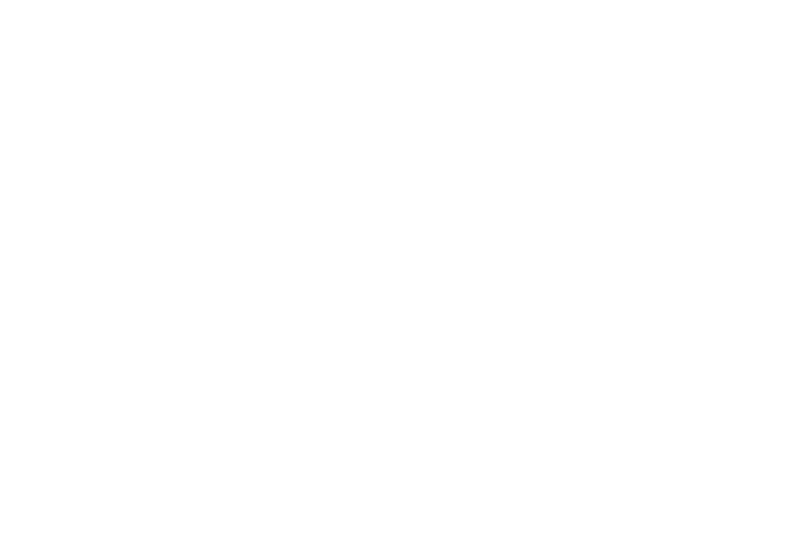

Resampling using SMOTE-Tomek-DT1: run 1 of 10.
Resampling using SMOTE-Tomek-DT1: run 2 of 10.
Resampling using SMOTE-Tomek-DT1: run 3 of 10.
Resampling using SMOTE-Tomek-DT1: run 4 of 10.
Resampling using SMOTE-Tomek-DT1: run 5 of 10.
Resampling using SMOTE-Tomek-DT1: run 6 of 10.
Resampling using SMOTE-Tomek-DT1: run 7 of 10.
Resampling using SMOTE-Tomek-DT1: run 8 of 10.
Resampling using SMOTE-Tomek-DT1: run 9 of 10.
Resampling using SMOTE-Tomek-DT1: run 10 of 10.


<IPython.core.display.Javascript object>


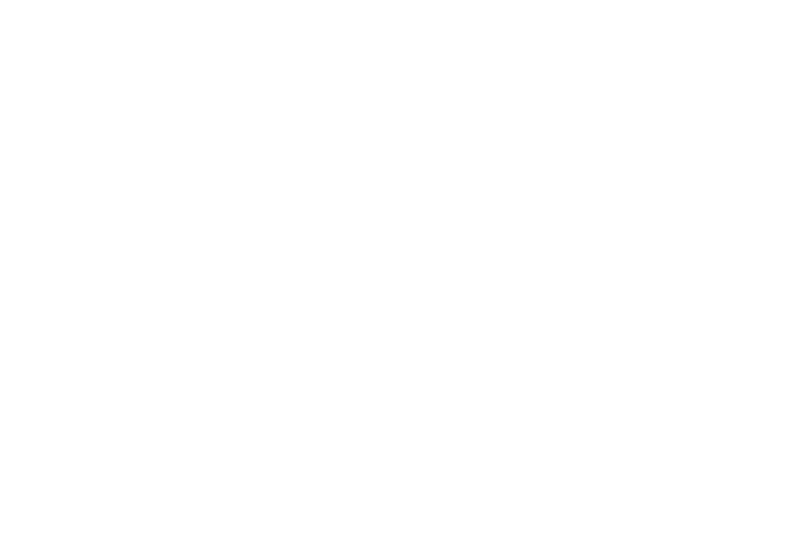

<IPython.core.display.Javascript object>


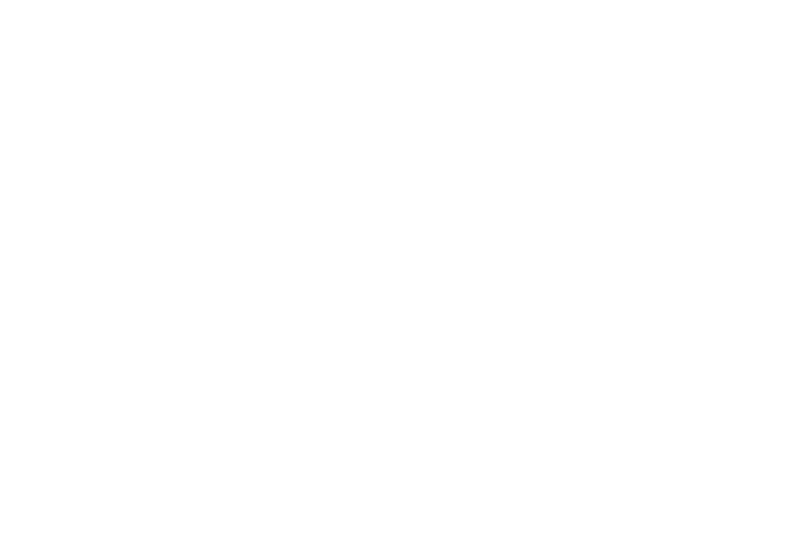

In [5]:
### Plot PR Curves for each resampler in `samplers`
## Based on examples for ROC curves from sklearn
## http://scikit-learn.org/stable/auto_examplesmodel_selection/plot_roc_crossval.html
## and imblearn
## https://glemaitre.github.io/imbalanced-learn/auto_examples/applications/plot_over_sampling_benchmark_lfw.html
mean_rec = np.linspace(0,1,100)
pr_results = {}
for name, pipeline in pipelines:
    pres = []
    pr_aucs = []
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1);
    i = 0
    # Compute PR curve with cross validation
    for train, test in cv.split(X, y):
        print("Resampling using {}: run {} of {}.".format(name, i+1, n_splits))
        probas_ = pipeline.fit(X.iloc[train], y[train]).predict_proba(X.iloc[test])
        pre, rec, pr_thresholds = precision_recall_curve(y[test], probas_[:,1])
        # Force high precision at high thresholds
        # pre[pre==0.0] = 1.0
        pres.append(interp(mean_rec, rec[::-1], pre[::-1]))
        pr_auc = auc(rec, pre)
        pr_aucs.append(pr_auc)
        _ = plt.plot(mean_rec, pres[-1], lw=1, alpha=0.3,
                     label='PR fold %d (AUC = %0.2f)' % (i, pr_auc));
        i += 1
    
    ### Mean PR Curve
    mean_pre = np.mean(pres, axis=0)
    mean_pr_auc = auc(mean_rec, mean_pre)
    std_pr_auc = np.std(pr_aucs)
    _ = plt.plot(mean_rec, mean_pre, color='b', lw=2, alpha=0.8, 
                 label=r'Mean PR (AUC = %.2f $\pm$ %0.2f)' % (mean_pr_auc, std_pr_auc));
    ## Mean PR StDevs
    std_pre = np.std(pres, axis=0)
    pres_upper = np.minimum(mean_pre + std_pre, 1)
    pres_lower = np.maximum(mean_pre - std_pre, 0)
    _ = plt.fill_between(mean_rec, pres_lower, pres_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.');
    ## Format PR Plot
    _ = plt.xlim([-0.05, 1.05]);
    _ = plt.ylim([-0.05, 1.05]);
    _ = plt.xlabel('Recall');
    _ = plt.ylabel('Precision');
    _ = plt.title('PR Curve for {}'.format(name));
    _ = plt.legend(loc="lower left");
    plt.show()
    
    pr_results[name] = (name, mean_pre, std_pre, mean_rec, mean_pr_auc)
    
fig = plt.figure();
ax = fig.add_subplot(1, 1, 1);
_ = plt.plot([0, 1], [1, 0], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8);
for key in pr_results:
    name, mean_pre, std_pre, mean_rec, mean_pr_auc = pr_results[key]
    _ = plt.plot(mean_rec, mean_pre, label=name, lw=2, alpha=.8);
    pres_upper = np.minimum(mean_pre + std_pre, 1)
    pres_lower = np.maximum(mean_pre - std_pre, 0)
    _ = plt.fill_between(mean_rec, pres_lower, pres_upper, alpha=.2);

_ = plt.xlim([-0.05, 1.05]);
_ = plt.ylim([-0.05, 1.05]);
_ = plt.xlabel('Recall');
_ = plt.ylabel('Precision');
_ = plt.title('Precision-Recall');
_ = plt.legend(loc="lower left");
plt.show()

<a id='application'></a>

### 3. Application

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform
from sklearn.metrics import fbeta_score, make_scorer

# Split train and test data
test_size = 0.2
[X, X_test, y, y_test] = train_test_split(data.drop('Class',axis=1), data['Class'], test_size=test_size, random_state=random_state)

# Reset indices from train data, to avoid confusion during cross-validation
Xind = X.index
y.ind = y.index
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
# X.set_index(Xind, inplace=True)
# y.set_index(yind, inplace=True)

n_splits  = 2
cv = StratifiedKFold(n_splits=n_splits, random_state=random_state)

f2_scorer = make_scorer(fbeta_score, beta=2)

clf = LogisticRegression(solver='saga', random_state=random_state)
param_dist = {'C': uniform(loc=0, scale=2)}

# clf = LinearRegression()
# param_dist = {}

#clf = AdaBoostClassifier()
#base_estimators = [DecisionTreeClassifier(random_state=random_state, max_depth=max_depth) for max_depth in [1,3]]
#param_dist = {'base_estimator': base_estimators,
#              'n_estimators': [5, 50],
#              'learning_rate': uniform(loc=0, scale=1)}

samplers = [
    ['Standard', DummySampler()],
#    ['ROS', RandomOverSampler(random_state=random_state)],
#    ['SMOTE', SMOTE(random_state=random_state)],
#    ['SMOTE-b1', SMOTE(random_state=random_state, kind='borderline1')],
#    ['SMOTE-b2', SMOTE(random_state=random_state, kind='borderline2')],
#    ['SMOTE-svm', SMOTE(random_state=random_state, kind='svm')],
#    ['ADASYN', ADASYN(random_state=random_state)],
#    ['RUS', RandomUnderSampler(random_state=random_state)],
#    ['NearMiss-1', NearMiss(random_state=random_state, version=1)],
#    ['NearMiss-2', NearMiss(random_state=random_state, version=2)],
#    ['NearMiss-3', NearMiss(random_state=random_state, version=3)],
#    ['Tomek', TomekLinks(random_state=random_state)],
#    ['EditedNN', EditedNearestNeighbours(random_state=random_state)],
#    ['RepeatedEditedNN', RepeatedEditedNearestNeighbours(random_state=random_state)],
#    ['AllKNN', AllKNN(random_state=random_state)],
#    ['CondensedNN', CondensedNearestNeighbour(random_state=random_state)],
#    ['OneSidedSelection', OnesidedSelection(random_state=random_state)],
#    ['NeighbourCleaning', NeighbourhoodCleaningRule(random_state=random_state)],
#    ['InstanceHardnessThreshold', InstanceHardnessThreshold(random_state=random_state)],
#    ['SMOTE-ENN', SMOTEENN(random_state=random_state)],
#    ['SMOTE-Tomek', SMOTETomek(random_state=random_state)],
]

sampler = samplers[0]

ppl = make_pipeline(sampler[1], clf)

# run randomized search
n_iter_search = 3
random_search = RandomizedSearchCV(ppl, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   scoring=f2_scorer,
                                   cv=cv,
                                   random_state=random_state,
                                   verbose=50)
random_search.fit(X, y)

In [ ]:
random_search.cv_results_

In [ ]:
### Illustrate F score using naive predictor
TP = np.sum(data['Class'])
FP = data['Class'].count() - TP
TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

accuracy  = (TP+TN)/(1.0*(TP+FP+TN+FN))
recall    = TP     /(1.0*(TP      +FN))
precision = TP     /(1.0*(TP+FP      ))

beta = 1
fscore = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Resampling using Standard-DT: run 1 of 10.
Resampling using Standard-DT: run 2 of 10.
Resampling using Standard-DT: run 3 of 10.
Resampling using Standard-DT: run 4 of 10.
Resampling using Standard-DT: run 5 of 10.
Resampling using Standard-DT: run 6 of 10.
Resampling using Standard-DT: run 7 of 10.
Resampling using Standard-DT: run 8 of 10.
Resampling using Standard-DT: run 9 of 10.
Resampling using Standard-DT: run 10 of 10.


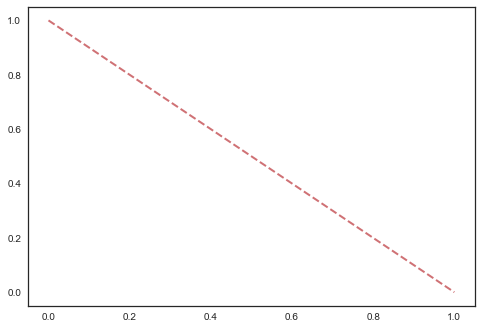

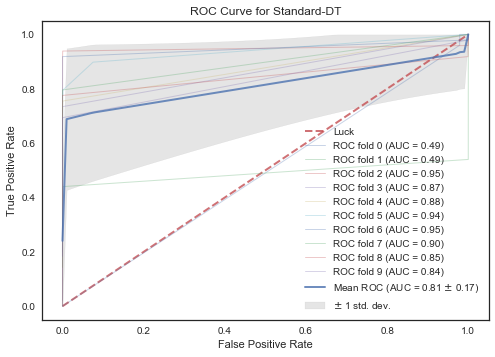

Resampling using ROS-DT: run 1 of 10.
Resampling using ROS-DT: run 2 of 10.
Resampling using ROS-DT: run 3 of 10.
Resampling using ROS-DT: run 4 of 10.
Resampling using ROS-DT: run 5 of 10.
Resampling using ROS-DT: run 6 of 10.
Resampling using ROS-DT: run 7 of 10.
Resampling using ROS-DT: run 8 of 10.
Resampling using ROS-DT: run 9 of 10.
Resampling using ROS-DT: run 10 of 10.


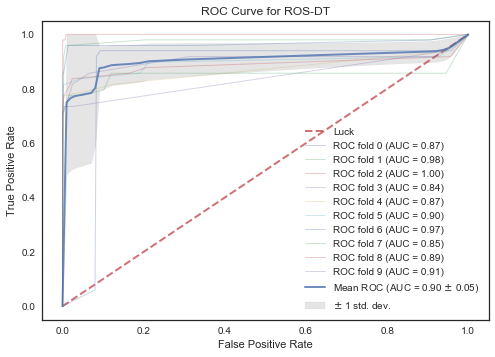

Resampling using SMOTE-DT: run 1 of 10.
Resampling using SMOTE-DT: run 2 of 10.
Resampling using SMOTE-DT: run 3 of 10.
Resampling using SMOTE-DT: run 4 of 10.
Resampling using SMOTE-DT: run 5 of 10.
Resampling using SMOTE-DT: run 6 of 10.
Resampling using SMOTE-DT: run 7 of 10.
Resampling using SMOTE-DT: run 8 of 10.
Resampling using SMOTE-DT: run 9 of 10.
Resampling using SMOTE-DT: run 10 of 10.


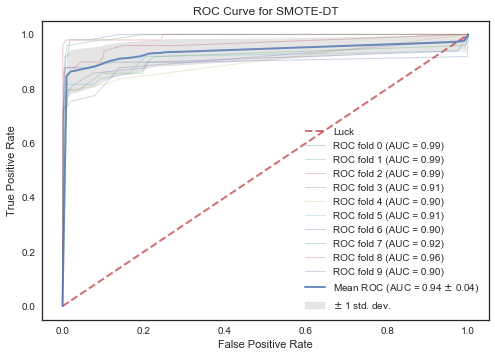

Resampling using SMOTE-b1-DT: run 1 of 10.
Resampling using SMOTE-b1-DT: run 2 of 10.
Resampling using SMOTE-b1-DT: run 3 of 10.
Resampling using SMOTE-b1-DT: run 4 of 10.
Resampling using SMOTE-b1-DT: run 5 of 10.
Resampling using SMOTE-b1-DT: run 6 of 10.
Resampling using SMOTE-b1-DT: run 7 of 10.
Resampling using SMOTE-b1-DT: run 8 of 10.
Resampling using SMOTE-b1-DT: run 9 of 10.
Resampling using SMOTE-b1-DT: run 10 of 10.


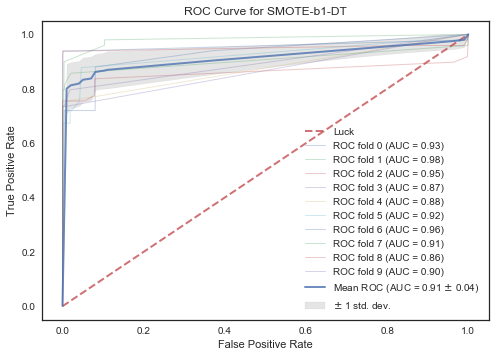

Resampling using SMOTE-b2-DT: run 1 of 10.
Resampling using SMOTE-b2-DT: run 2 of 10.
Resampling using SMOTE-b2-DT: run 3 of 10.
Resampling using SMOTE-b2-DT: run 4 of 10.
Resampling using SMOTE-b2-DT: run 5 of 10.
Resampling using SMOTE-b2-DT: run 6 of 10.
Resampling using SMOTE-b2-DT: run 7 of 10.
Resampling using SMOTE-b2-DT: run 8 of 10.
Resampling using SMOTE-b2-DT: run 9 of 10.
Resampling using SMOTE-b2-DT: run 10 of 10.


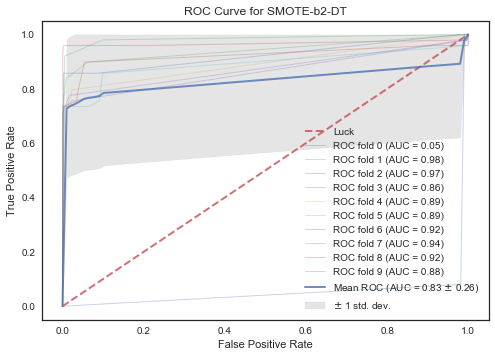

Resampling using ADASYN-DT: run 1 of 10.
Resampling using ADASYN-DT: run 2 of 10.
Resampling using ADASYN-DT: run 3 of 10.
Resampling using ADASYN-DT: run 4 of 10.
Resampling using ADASYN-DT: run 5 of 10.
Resampling using ADASYN-DT: run 6 of 10.
Resampling using ADASYN-DT: run 7 of 10.
Resampling using ADASYN-DT: run 8 of 10.
Resampling using ADASYN-DT: run 9 of 10.
Resampling using ADASYN-DT: run 10 of 10.


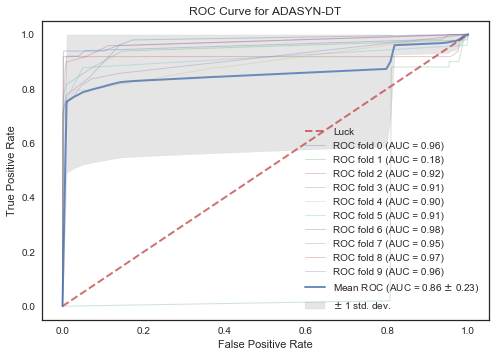

Resampling using SMOTE-ENN-DT: run 1 of 10.
Resampling using SMOTE-ENN-DT: run 2 of 10.
Resampling using SMOTE-ENN-DT: run 3 of 10.
Resampling using SMOTE-ENN-DT: run 4 of 10.
Resampling using SMOTE-ENN-DT: run 5 of 10.
Resampling using SMOTE-ENN-DT: run 6 of 10.
Resampling using SMOTE-ENN-DT: run 7 of 10.
Resampling using SMOTE-ENN-DT: run 8 of 10.
Resampling using SMOTE-ENN-DT: run 9 of 10.
Resampling using SMOTE-ENN-DT: run 10 of 10.


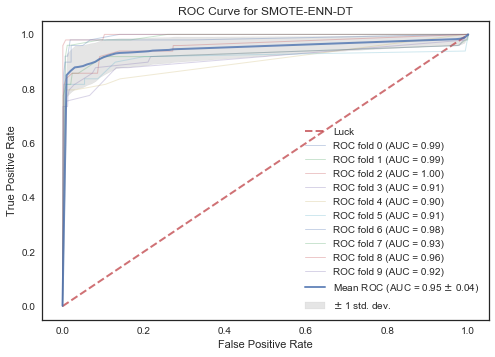

Resampling using SMOTE-Tomek-DT: run 1 of 10.
Resampling using SMOTE-Tomek-DT: run 2 of 10.
Resampling using SMOTE-Tomek-DT: run 3 of 10.
Resampling using SMOTE-Tomek-DT: run 4 of 10.
Resampling using SMOTE-Tomek-DT: run 5 of 10.
Resampling using SMOTE-Tomek-DT: run 6 of 10.
Resampling using SMOTE-Tomek-DT: run 7 of 10.
Resampling using SMOTE-Tomek-DT: run 8 of 10.
Resampling using SMOTE-Tomek-DT: run 9 of 10.
Resampling using SMOTE-Tomek-DT: run 10 of 10.


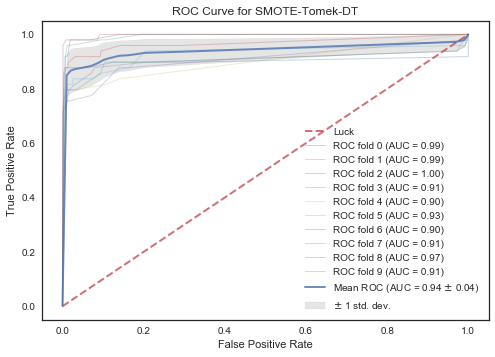

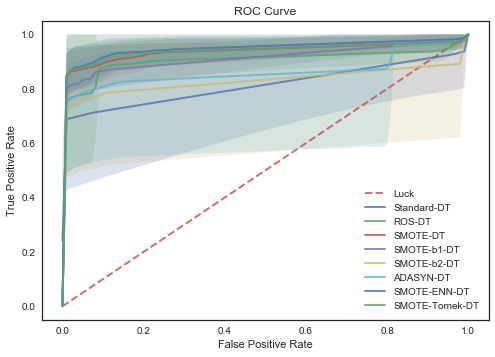

In [13]:
mean_fpr = np.linspace(0, 1, 100)
results = {}
for name, pipeline in pipelines:
    tprs = []
    aucs = []
    fig = plt.figure()
#    ax = fig.add_subplot(1, 1, 1);
    _ = plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                 label='Luck', alpha=.8);
    i = 0
    # Compute ROC curve with cross validation
    for train, test in cv.split(X, y):
        print("Resampling using {}: run {} of {}.".format(name, i+1, n_splits))
        probas_ = pipeline.fit(X.iloc[train], y[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, roc_thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
#        tprs[-1][0] = 0.0
#        tprs[-1][-1] = 1.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        _ = plt.plot(fpr, tpr, lw=1, alpha=0.3,
                     label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc));
        i += 1
    
    # Mean ROC Curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    _ = plt.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=.8,
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc));    
    # Mean ROC StDevs
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    _ = plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.');
    # Format ROC Plot
    _ = plt.xlim([-0.05, 1.05]);
    _ = plt.ylim([-0.05, 1.05]);
    _ = plt.xlabel('False Positive Rate');
    _ = plt.ylabel('True Positive Rate');
    _ = plt.title('ROC Curve for {}'.format(name));
    _ = plt.legend(loc="lower right");
    plt.show()
    
    results[name] = (name, mean_tpr, std_tpr, mean_fpr, mean_auc)
    
fig = plt.figure();
ax = fig.add_subplot(1, 1, 1);
_ = plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8);
for key in results:
    name, mean_tpr, std_tpr, mean_fpr, mean_auc = results[key]
    _ = plt.plot(mean_fpr, mean_tpr, label=name, lw=2, alpha=.8);
    pres_upper = np.minimum(mean_tpr + std_tpr, 1)
    pres_lower = np.maximum(mean_tpr - std_tpr, 0)
    _ = plt.fill_between(mean_rec, pres_lower, pres_upper, alpha=.2);

_ = plt.xlim([-0.05, 1.05]);
_ = plt.ylim([-0.05, 1.05]);
_ = plt.xlabel('False Positive Rate');
_ = plt.ylabel('True Positive Rate');
_ = plt.title('ROC Curve');
_ = plt.legend(loc="lower right");
plt.show()